In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from typing import List 
import pandas as pd 

%matplotlib inline
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import Flowers102
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns 

from planttraits.notebook_utils import BaseCNN, train_transforms, type_transforms, CNN, GoogleNetModule, ConvLayer, compute_dim
from lightning.pytorch.loggers import WandbLogger
import optuna
from optuna.trial import TrialState
import torch.optim as optim
from optuna.integration import PyTorchLightningPruningCallback

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_PATH = Path('../data/study')

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 266564 (farqlia-266564). Use `wandb login --relogin` to force relogin


True

### Uczenie transferowe
Dostosowywanie wytrenowanego wcześniej modelu na ogólnym zbiorze danych do konkretnego zadania. Jest to wskazane dla sytuacji, gdy docelowy zbiór danych jest niewielki i wytrenowanie całego modelu nie dałoby dobrego efektu. Dla przykładu dostosowania modelu widzenia komputerowego kroki są następujące: 
1. Preprocesowanie danych w *ten sam* sposób, w jaki były preprocesowane dla oryginalnego modelu
2. Wgranie modelu (architektura + wagi)
3. Usunięcie ostatnich warstw (zwykle liniowych, które służą do klasyfikacji)
4. Dodanie nowych warstw, gdzie ostatnia warstwa ma tyle neuronów, ile jest potrzebnych do naszego konkretnego zadania
5. **Zamrożenie** warstw modelu, których nie chcemy trenować (czyli zwykle tych oryginalnych), bez zamrażania naszych dodanych warstw


##### Co warto mieć na uwadze 
"Transfer learning" można podzielić ze względu na podobieństwo rozkładów danych, na których trenowano oryginalny model oraz rozkład docelowy. Docelowo chcielibyśmy, by te rozkłady się różniły tylko trochę, ale często tak nie jest. Ważne jednak by te dwa zadania (rozkłady) nie były całkowicie różne (przydatna analogia - umiejętność gry na pianinie nie pomaga w nauce jazdy na rowerze), gdyż możemy mieć wtedy do czynienia z *negatywnym transferem (negative transfer)*. Najlepiej jest wcześniej zapoznać się ze stanem nauki w zakresie *transfer learning* dla dziedziny, w której chcemy rozwiązać problem, i wtedy też zastosować model bezpośrednio do danych, żeby mieć później punkt odniesienia. Również dla bardziej tradycyjnych metod uczenia maszynowego zastosowanie tej metody może nie być tak oczywiste jak dla sieci neuronowych (np. potrzeba ważenia rozkładów oryginalnego i docelowego).

#### Inception
Wprowadzony w modelu *GoogleNet* blok *Inception* jest 'mini-modelem', który miał na celu wytrenowanie (jak na tamte czasy) bardziej efektywnej sieci przy takich samych zasobach. Aż trzy rozmiary konwolucji mają za zadanie wykrycie cech o różnym rozmiarze. Wykorzystanie kownolucji $1 \times 1$ ma na celu redukcję wymiarowości.
https://pytorch.org/vision/main/models/generated/torchvision.models.googlenet.html#torchvision.models.googlenet

<img src="images/inception-block.png" alt="inception" width="500"/>

Jednym z ciekawszych zabiegów w sieci *GoogleNet* jest zrezygnowanie z ostatniej warstwy klasyfikatora i użycie *Global Average Pooling*, które dla warstwy składającej się z $k$ filtrów oblicza średnią dla każdej mapy i zwraca wektor o długości $k$. 

In [5]:
gnet = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights).to(device)

c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
summary(gnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
       BasicConv2d-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
       BasicConv2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 192, 64, 64]         110,592
       BatchNorm2d-9          [-1, 192, 64, 64]             384
      BasicConv2d-10          [-1, 192, 64, 64]               0
        MaxPool2d-11          [-1, 192, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          12,288
      BatchNorm2d-13           [-1, 64, 32, 32]             128
      BasicConv2d-14           [-1, 64,

In [7]:
for mod in gnet.named_modules():
    print(mod)

('', GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, 

In [2]:
gnet_transforms = transforms.Compose([
    transforms.PILToTensor(),
    # Transpose(axes=(1, 2, 0)),
    transforms.Resize(size=(256, 256)),
    transforms.ConvertImageDtype(torch.float),
    transforms.CenterCrop(size=224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Flowers102(root=DATASET_PATH, 
                           split='test',
                           transform=gnet_transforms,
                           download=True)
test_dataset = Flowers102(root=DATASET_PATH, 
                           split='train',
                           transform=gnet_transforms,
                           download=True)
val_dataset = Flowers102(root=DATASET_PATH, 
                           split='val',
                           transform=gnet_transforms,
                           download=True)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
help(gnet)

Help on GoogLeNet in module torchvision.models.googlenet object:

class GoogLeNet(torch.nn.modules.module.Module)
 |  GoogLeNet(num_classes: int = 1000, aux_logits: bool = True, transform_input: bool = False, init_weights: Optional[bool] = None, blocks: Optional[List[Callable[..., torch.nn.modules.module.Module]]] = None, dropout: float = 0.2, dropout_aux: float = 0.7) -> None
 |  
 |  Method resolution order:
 |      GoogLeNet
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_classes: int = 1000, aux_logits: bool = True, transform_input: bool = False, init_weights: Optional[bool] = None, blocks: Optional[List[Callable[..., torch.nn.modules.module.Module]]] = None, dropout: float = 0.2, dropout_aux: float = 0.7) -> None
 |      Initialize internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  eager_outputs(self, x: torch.Tensor, aux2: torch.Tensor, aux1: Optional[torch.Tensor]) -> torchvision.mo

In [8]:
gnet = GoogleNetModule()
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'gnet-tl'
wandb_logger = WandbLogger(project="CNN", name=model_name, log_model=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
max_epochs = 25

trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir=checkpoint_dir / model_name, 
                     fast_dev_run=False, # True dla szybkiego przebiegu sprawdzającego, czy wszystkie warstwy są poprawne itd.
                     callbacks=[checkpoint_callback, early_stopping],
                     logger=wandb_logger   # use this instead of default tensorboard
                     )
wandb_logger.watch(gnet, log='all') # loguje parametry i gradienty
trainer.fit(gnet, train_loader, val_loader)
wandb.finish()

c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | gnet   | GoogLeNet          | 6.2 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
577 K     Trainable params
5.6 M     Non-trainable params
6.2 M     Total params
24.708    Total estimated model params size (MB)
229       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 2.291


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.064 >= min_delta = 0.0. New best score: 1.227


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.392 >= min_delta = 0.0. New best score: 0.835


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.734


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 0.615


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 0.547


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.525


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.471


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.439


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.439. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
train_acc_epoch,▁▅▆▇▇▇█████████
train_acc_step,▁▃▅▄▅▇▇▆▇▆▇█▇▇▇██▇▇█▇█▇▇▇██▇▇
train_loss_epoch,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
train_loss_step,█▆▃▄▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▅▇▇▇█▇██▇█████
val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,14
train_acc_epoch,0.94129
train_acc_step,0.92188


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='f1_score', ylabel='Count'>

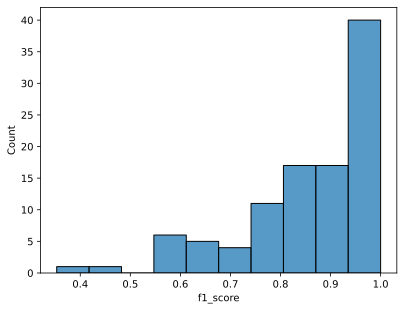

In [12]:
trainer = pl.Trainer()
y_test = trainer.predict(gnet, dataloaders=test_loader)
y_labels = np.concatenate([labels.cpu().numpy() for _, labels in iter(test_loader)])

precision, recall, f1score, support = precision_recall_fscore_support(y_labels, torch.concat(y_test).numpy())
clf_report_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1score, 'support': support},
                                 index=(np.arange(102)))
sns.histplot(data=clf_report_df, x='f1_score')

### CMAP 
Class Activation Map służy do odkrywania obszarów, na które zwracają uwagę wyuczone w sieciach konwolucyjnych filtry. Jednocześnie zastosujemy trochę inny schemat dla klasyfikującej sieci konwolucyjnej, gdzie zamiast kilku warstw liniowych na końcu użyjemy warstwy pooling'u, która dla każdej mapy obliczy średnią jej wartości. Wtedy też interpretujemy połączenia między ostatnią warstwą konwolucyjną a warstwą liniową jako te wskazujące na cechy istotne dla danej klasy - z tego też powodu użyjemy tych wag dla przeskalowania map cech, by znaleźć obszary istotne dla klasyfikacji wybranej klasy. Warto zauważyć, że jest to zadanie zbliżone trochę do detekcji obiektów, mimo iż nie uzywamy żadnego bounding box'a.  

<img src="images/cmap-2.png" alt="cmap" width="800"/>



In [46]:
d = compute_dim(256, kernel=3, padding=1, stride=1)
d = compute_dim(d, kernel=3, padding=1, stride=2)
d = compute_dim(d, kernel=3, padding=1, stride=2)
d = compute_dim(d, kernel=3, padding=1, stride=1)
d = compute_dim(d, kernel=3, padding=1, stride=2)
d = compute_dim(d, kernel=3, padding=1, stride=2)
d = compute_dim(d, kernel=3, padding=1, stride=2)
d

8

In [47]:
conv_layers = [
    ConvLayer(3, 32, 3, padding=1, stride=1, batch_norm=True),  # C, W, H = ()
    ConvLayer(32, 64, 3, padding=1, stride=2, batch_norm=True),
    ConvLayer(64, 64, 3, padding=1, stride=2, batch_norm=True),
    ConvLayer(64, 128, 3, padding=1, stride=1, batch_norm=True),
    ConvLayer(128, 256, 3, padding=1, stride=2, batch_norm=True),
    ConvLayer(256, 512, 3, padding=1, stride=2, batch_norm=True),
    ConvLayer(512, 1024, 3, padding=1, stride=2, batch_norm=True),
    nn.AdaptiveAvgPool2d(output_size=1)
]

linear_layers = [
    nn.Linear(1024, 102)
]

In [48]:
base_cnn = BaseCNN(conv_layers=conv_layers, linear_layers=linear_layers)
cnn = CNN(base_cnn)

In [49]:
output = cnn(torch.randn(32, 3, 256, 256))

In [55]:
output.shape

torch.Size([32, 102])

In [51]:
train_dataset = Flowers102(root=DATASET_PATH, 
                           split='test',
                           transform=train_transforms,
                           download=True)
test_dataset = Flowers102(root=DATASET_PATH, 
                           split='train',
                           transform=type_transforms,
                           download=True)
val_dataset = Flowers102(root=DATASET_PATH, 
                           split='val',
                           transform=type_transforms,
                           download=True)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [52]:
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'cnn-cmap'
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
max_epochs = 25

trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir=checkpoint_dir / model_name, 
                     fast_dev_run=False, # True dla szybkiego przebiegu sprawdzającego, czy wszystkie warstwy są poprawne itd.
                     callbacks=[checkpoint_callback, early_stopping]
                     )

trainer.fit(cnn, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\julia\VSCode\PlantTraits2024\models\cnn-cmap exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | cnn    | BaseCNN            | 6.4 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.735    Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 3.496


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.220 >= min_delta = 0.0. New best score: 3.276


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 3.213


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.419 >= min_delta = 0.0. New best score: 2.794


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 2.725


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 2.715


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 2.627


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 2.474


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 2.453


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.265 >= min_delta = 0.0. New best score: 2.188


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 2.070


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 2.051


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 2.040


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 2.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 1.871


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.126 >= min_delta = 0.0. New best score: 1.745


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.669


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [58]:
for mod in cnn.named_modules():
    print(mod)

('', CNN(
  (cnn): BaseCNN(
    (conv_layers): Sequential(
      (0): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (3): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

Kolejnym krokiem jest wydobycie z modelu ostatniej warstwy liniowej i uzyskanie wyniku dla ostatniej warstwy konwolucyjnej 

In [ ]:
linear_layer = cnn.cnn.lin_layers[0]

In [72]:
for param in linear_layer.parameters():
    print(param.data.shape)

torch.Size([102, 1024])
torch.Size([102])


In [136]:
imgs, labels = next(iter(test_loader))

In [137]:
imgs.shape

torch.Size([64, 3, 256, 256])

In [138]:
last_conv_output = cnn.cnn.conv_layers[:-1](imgs[:1]) # ostatnia warstwa to pooling dlatego ją pomijamy
last_conv_output.shape

torch.Size([1, 1024, 8, 8])

Aby uzyskać mapę ciepła, trzeba po kolei wymnożyć każdą mapę z odpowiadającą jej wagą połączenia dla wybranej klasy

In [139]:
# img: (1, C, H, W)
def scale_by_map(model, img, lin_layer, class_idx):
    last_conv_output = model(img).squeeze(dim=0)
    lin_params = list(lin_layer.parameters())

    CAM = torch.sum(last_conv_output * lin_params[0][class_idx, :, None, None] + lin_params[1][class_idx, None, None], axis=0)
    return CAM 

In [140]:
cam = scale_by_map(cnn.cnn.conv_layers[:-1], imgs[0:1], linear_layer, 0)

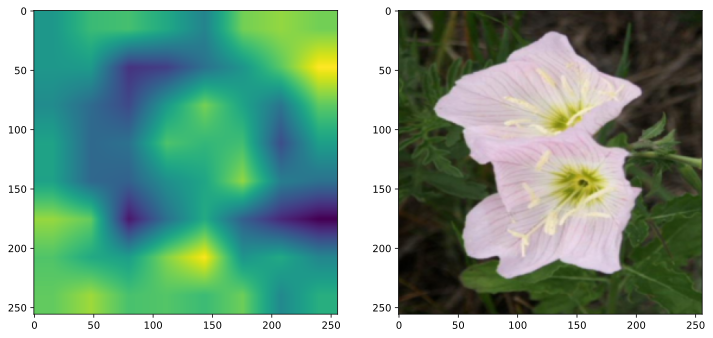

In [146]:
import cv2
img_idx = 4
cam = scale_by_map(cnn.cnn.conv_layers[:-1], imgs[img_idx:img_idx+1], linear_layer, labels[img_idx].numpy())
img_np = imgs[img_idx].numpy().transpose(1, 2, 0)
heatmap = cv2.resize(cam.detach().numpy(), (img_np.shape[0], img_np.shape[1]))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(heatmap)
plt.subplot(1, 2, 2)
plt.imshow(img_np)

### ResNet
W przypadku głębokich sieci (ogólnie, nie tylko konwolucyjnych) pojawia się zjawisko *większego* błędu niż dla płytkich sieci. Nie jest to stricte związane z przetrenowaniem, gdyż wyższy błąd obserwuje się zarówno dla zbioru treningowego, jak i testowego. Intuicyjnie można podejrzewać, że głębsze sieci powinny być nie gorsze od rzadszych, bo z tych drugich można 'skopiować' wagi, a pozostałe warstwy mogą po prostu reprezentować funkcje tożsamościowe (czyli $y = f(x) = x$). Tak się jednak nie dzieje. Jako ratunek służy nowy rodzaj 'klocka budulcowego', zwany *blokiem resztkowym* (residual block). Taki block reprezentuje funkcję $$ H(x) := F(x) + x $$

<img src="images/blok%20resztkowy.png" width="400" />

Dzięki takiemu projektowi sieć nie musi się uczyć funkcji tożsamościowej poprzez warstwy nieliniowe. Zwykle taki blok ma 2-3 warstwy nieliniowe (dla 1 warstwy nie daje to polepszonego efektu). Wymaga to jednak tego, by wyjście i wejście były tego samego rozmiaru. Jeśli jednak tak nie jest, to można dodać zwykłe przekształcenie liniowe do $x$ $$ H(x) := F(x) + W_x x $$

In [33]:
class ConvResLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernels=[3, 3], 
                 strides=[1, 2], paddings=[1, 1], activ=nn.ReLU,
                 # parametry dla przekształcenia zmieniającego rozmiar wyjścia
                 d_k=None, d_p=None, d_s=None):
        super(ConvResLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernels[0], stride=strides[0],
                            padding=paddings[0]),
            nn.BatchNorm2d(out_channels),
            activ(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernels[1], stride=strides[1],
                            padding=paddings[1]),
            nn.BatchNorm2d(out_channels),                
        ]
        
        self.layers = nn.Sequential(*layers)

        self.downsample_conv = nn.Conv2d(in_channels, out_channels, kernel_size=d_k, stride=d_s,
                            padding=d_p) if d_k else None 
        self.final_act = activ()
        
    def forward(self, x):
        z = self.layers(x)
        if self.downsample_conv:
            x = self.downsample_conv(x)
        # ostatnia aktywacja jest aplikowana już po dodaniu
        z = self.final_act(x + z) 
        return z 

In [34]:
conv_block = ConvResLayer(
    in_channels=3, out_channels=64, d_k=3, d_p=1, d_s=2
)
t = torch.randn(64, 3, 256, 256)

In [35]:
conv_blocks = [
    ConvResLayer(in_channels=3, out_channels=32, d_k=3, d_p=1, d_s=2),
    ConvResLayer(in_channels=32, out_channels=64, d_k=3, d_p=1, d_s=2),
    ConvResLayer(in_channels=64, out_channels=64, d_k=3, d_p=1, d_s=2),
    ConvResLayer(in_channels=64, out_channels=128, d_k=3, d_p=1, d_s=2),
    ConvResLayer(in_channels=128, out_channels=256, d_k=3, d_p=1, d_s=2),
    ConvResLayer(in_channels=256, out_channels=256, strides=[2, 2], d_k=3, d_p=1, d_s=4),
]

input_dim = 256 * 2 * 2 # C x W x H
n_classes = 102

linear_layers = [
    nn.Sequential(nn.Linear(input_dim, 1024), nn.BatchNorm1d(1024)),
    nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512)),
    nn.Linear(512, n_classes),
]

In [36]:
nn.Sequential(*conv_blocks)(t).shape

torch.Size([64, 256, 2, 2])

In [37]:
cnn = BaseCNN(conv_layers=conv_blocks, linear_layers=linear_layers)

In [38]:
pred = cnn(t)
pred.shape

torch.Size([64, 102])

### Inicjalizacja wag
Inicjalizacja wag może mieć wpływ na problem znikających / wybuchających gradientów, gdzie dla głębokich sieci gradient wsteczny może zanikać, ponieważ zależy też od wag. Normalnie implementując sieć nie martwimy się tym, bo domyślnie robi to pytorch (sposób inicjalizacji zależy od konkretnego modułu, np. Linear, Conv itd.). Można wykorzystać funkcje [nn.init](https://pytorch.org/docs/main/nn.init.html) aby 'ręcznie' dobrać odpowiedni sposób. Jedną z lepszych metod jest inicjalizacja [Xavier'a](https://pouannes.github.io/blog/initialization/).

In [59]:
def normal_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)


def xavier_uniform(model):
    for name, param in model.named_parameters():
        if len(param.shape) > 2:
            nn.init.xavier_uniform_(param)

In [61]:
checkpoint_dir = Path(f'../models')

train_dataset = Flowers102(root=DATASET_PATH, 
                           split='test',
                           transform=train_transforms,
                           download=True)
test_dataset = Flowers102(root=DATASET_PATH, 
                           split='train',
                           transform=type_transforms,
                           download=True)
val_dataset = Flowers102(root=DATASET_PATH, 
                           split='val',
                           transform=type_transforms,
                           download=True)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)    


In [62]:
def objective(trial):
    init_func = trial.suggest_categorical("init_type", ["normal", "xavier", "default"])
    cnn = BaseCNN(conv_layers=conv_blocks, linear_layers=linear_layers)

    if init_func == "normal":
        normal_init(cnn)
    elif init_func == "xavier":
        xavier_uniform(cnn)

    model = CNN(cnn)

    model_name = 'resnet-cnn' + str(trial.number)
    early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

    trainer = pl.Trainer(
        default_root_dir=checkpoint_dir / model_name,
        max_epochs=25,
        callbacks=[early_stopping]
    )
    trainer.fit(model, train_loader, val_loader)

    # callback_metrics - to co jest logowane przy pomocy metody 'log'
    return trainer.callback_metrics["val_acc"].item()

In [63]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

[I 2024-12-30 19:12:57,720] A new study created in memory with name: no-name-f9ebfb8d-f8be-4399-86f1-5c6ef8d3f0c4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | cnn    | BaseCNN            | 5.1 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.299    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 4.413


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 4.411


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.392 >= min_delta = 0.0. New best score: 4.019


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 3.886


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: 3.711


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 3.635


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 3.504


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 3.254


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 3.173


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 3.109


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.222 >= min_delta = 0.0. New best score: 2.887


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 2.842


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 2.689


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2.689. Signaling Trainer to stop.
[I 2024-12-30 19:59:22,014] Trial 0 finished with value: 0.34215685725212097 and parameters: {'init_type': 'normal'}. Best is trial 0 with value: 0.34215685725212097.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | cnn    | BaseCNN            | 5.1 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.299    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 2.734


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2.734. Signaling Trainer to stop.
[I 2024-12-30 20:07:03,768] Trial 1 finished with value: 0.3598039150238037 and parameters: {'init_type': 'default'}. Best is trial 1 with value: 0.3598039150238037.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | cnn    | BaseCNN            | 5.1 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.299    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 3.578


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.549 >= min_delta = 0.0. New best score: 3.029


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.428 >= min_delta = 0.0. New best score: 2.601


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2.601. Signaling Trainer to stop.
[I 2024-12-30 20:16:07,589] Trial 2 finished with value: 0.3186274468898773 and parameters: {'init_type': 'xavier'}. Best is trial 1 with value: 0.3598039150238037.
